In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size, udf, sum, count, countDistinct

import pyspark.sql.functions as func
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

import numpy as np
from math import floor, ceil
from itertools import zip_longest
from numpy.linalg import inv

In [14]:
"""
def within(limits, x):
    assert limits.shape == (len(x), 2), "Invalid k-space limits!"
    return np.all(x > limits[:, 0]) and np.all(x < limits[:, 1])

# test:
limits = np.arange(6).reshape((3, 2))
print(limits)
x1 = np.array([2, 3, 4])
print(within(limits, x1))
x2 = np.array([0.5, 2.5, 4.5])
print(within(limits, x2))
"""

'\ndef within(limits, x):\n    assert limits.shape == (len(x), 2), "Invalid k-space limits!"\n    return np.all(x > limits[:, 0]) and np.all(x < limits[:, 1])\n\n# test:\nlimits = np.arange(6).reshape((3, 2))\nprint(limits)\nx1 = np.array([2, 3, 4])\nprint(within(limits, x1))\nx2 = np.array([0.5, 2.5, 4.5])\nprint(within(limits, x2))\n'

In [57]:
def occupancy_BZ(infile, W=np.eye(3)):
    spark = SparkSession.builder.master('local').appName("slice").getOrCreate()
    dataschema = StructType([ StructField("H", FloatType(), False), \
                              StructField("K", FloatType(), False), \
                              StructField("L", FloatType(), False), \
                              StructField("E", FloatType(), False), \
                              StructField("I", FloatType(), False)])
    df = spark.read.csv(infile, sep=",", schema=dataschema)
    if np.allclose(W, np.eye(3)):
        df_BZ = df.withColumn("BZ_H", func.round(df.H)).withColumn("BZ_K", func.round(df.K)).withColumn("BZ_L", func.round(df.L))
    else:
        print("Transform applied...")
        inv_W = inv(W)
        df_BZ = df.withColumn("BZ_H", func.round(inv_W[0, 0] * df.H + inv_W[0, 1] * df.K + inv_W[0, 2] * df.L))\
                  .withColumn("BZ_K", func.round(inv_W[1, 0] * df.H + inv_W[1, 1] * df.K + inv_W[1, 2] * df.L))\
                  .withColumn("BZ_L", func.round(inv_W[2, 0] * df.H + inv_W[2, 1] * df.K + inv_W[2, 2] * df.L))
    stat_BZ = np.array(df_BZ.groupBy("BZ_H", "BZ_K", "BZ_L").count().collect()).astype(int)
    spark.stop()
    return stat_BZ[stat_BZ[:, -1].argsort()]

# test1:
infile = "/Users/shenyang/Documents/NaBr/INS-code/QEI_no_nan_no_zero.csv"
W = np.array([[-1, 1, 1], [1, -1, 1], [1, 1, -1]])
res2 = occupancy_BZ(infile, W)
print(res2)

Transform applied...
[[     -3      -3       0       2]
 [      1      -1      -2       2]
 [      2       2      -2       2]
 [     -1       1      -1       4]
 [      0      -2      -5       9]
 [     -2       0      -5      13]
 [     -1       0      -5      14]
 [     -4      -2      -1      31]
 [      1       2       0      35]
 [      0      -1      -5      41]
 [     -3      -1       0      42]
 [     -5      -3      -3      51]
 [     -4      -2      -5      57]
 [     -2      -4      -1      60]
 [     -5      -3      -4      65]
 [     -1      -3       0      69]
 [     -2      -4      -5      73]
 [     -3      -4      -1      75]
 [      2       1       0      77]
 [     -4      -3      -1      80]
 [     -3      -1      -5      88]
 [     -3      -5      -4      94]
 [     -3      -5      -3     106]
 [      0      -1       1     112]
 [     -5      -4      -4     122]
 [     -1      -3      -5     126]
 [     -4      -5      -3     130]
 [     -1       0       1     138]

[      2       2       1 9468602]
[-5 -5 -5  2]


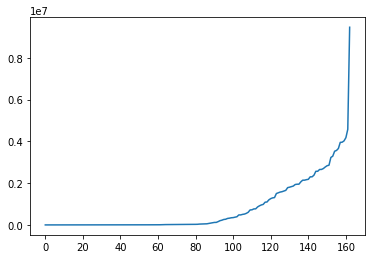

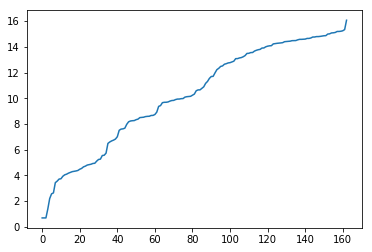

In [48]:
print(np.amax(res, axis=0))
print(np.amin(res, axis=0))
import matplotlib.pyplot as plt
plt.plot(res[:, -1])
plt.show()
plt.cla()
plt.plot(np.log(res[:, -1]))
plt.show()

In [49]:
# test2:
infile = "/Users/shenyang/Documents/NaBr/INS-code/HKLEI_no_nan_no_zero.csv"
res = occupancy_BZ(infile)
print(res)

[[     -4      -2      -3       1]
 [     -2      -4      -2       1]
 [      0      -2       1       2]
 [     -2       0       1       6]
 [     -3      -3      -4       8]
 [      3       3      -4      10]
 [     -2      -1       1      11]
 [     -2      -2      -5      12]
 [     -1      -2       1      13]
 [      2       2      -5      16]
 [     -3      -3      -1      21]
 [     -3      -2       0      22]
 [      2       4      -3      22]
 [     -2      -3       0      26]
 [      2       3      -1      28]
 [      4       2      -3      43]
 [      3       2      -1      47]
 [      0       2      -1      47]
 [      0       2       1      91]
 [      0       2      -5     192]
 [     -3      -1       0     192]
 [     -2       0      -5     206]
 [      1       2       0     236]
 [      1       2      -5     237]
 [      0      -2      -5     243]
 [     -2      -1      -5     245]
 [      2       0      -5     246]
 [      2       1      -5     282]
 [     -1      -2   

[      4       4       1 7605926]
[-4 -4 -5  1]


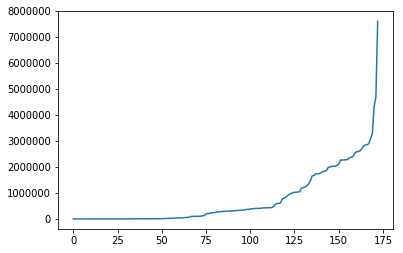

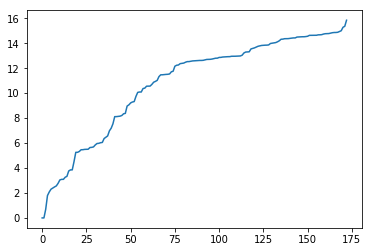

In [50]:
print(np.amax(res, axis=0))
print(np.amin(res, axis=0))
import matplotlib.pyplot as plt
plt.plot(res[:, -1])
plt.show()
plt.cla()
plt.plot(np.log(res[:, -1]))
plt.show()

In [56]:
def occupancy_BZ_near(infile, W=np.eye(3), grid=0.1):
    spark = SparkSession.builder.master('local').appName("slice").getOrCreate()
    dataschema = StructType([ StructField("H", FloatType(), False), \
                              StructField("K", FloatType(), False), \
                              StructField("L", FloatType(), False), \
                              StructField("E", FloatType(), False), \
                              StructField("I", FloatType(), False)])
    df = spark.read.csv(infile, sep=",", schema=dataschema)
    if np.allclose(W, np.eye(3)):
        df_BZ = df.withColumn("BZ_H", func.round(df.H)).withColumn("BZ_K", func.round(df.K)).withColumn("BZ_L", func.round(df.L))
    else:
        print("Transform applied...")
        inv_W = inv(W)
        df_BZ = df.withColumn("H_", inv_W[0, 0] * df.H + inv_W[0, 1] * df.K + inv_W[0, 2] * df.L)\
                .withColumn("K_", inv_W[1, 0] * df.H + inv_W[1, 1] * df.K + inv_W[1, 2] * df.L)\
                .withColumn("L_", inv_W[2, 0] * df.H + inv_W[2, 1] * df.K + inv_W[2, 2] * df.L).cache()\
                .withColumn("BZ_H", func.round(col("H_")))\
                .withColumn("BZ_K", func.round(col("K_")))\
                .withColumn("BZ_L", func.round(col("L_")))\
                .withColumn("sub_BZ_H", func.round( (col("H_")-col("BZ_H"))/grid ))\
                .withColumn("sub_BZ_K", func.round( (col("K_")-col("BZ_K"))/grid ))\
                .withColumn("sub_BZ_L", func.round( (col("L_")-col("BZ_L"))/grid ))
    stat_BZ = np.array(df_BZ.groupBy("BZ_H", "BZ_K", "BZ_L")\
                            .agg(countDistinct("sub_BZ_H", "sub_BZ_K", "sub_BZ_L"))\
                            .collect()\
                      ).astype(int)
    spark.stop()
    return stat_BZ[stat_BZ[:, -1].argsort()]

#test:
infile = "/Users/shenyang/Documents/NaBr/INS-code/QEI_no_nan_no_zero.csv"
W = np.array([[-1, 1, 1], [1, -1, 1], [1, 1, -1]])
res1 = occupancy_BZ_near(infile, W)
print(res1)

Transform applied...
[[  -3   -3    0    1]
 [   1   -1   -2    1]
 [  -1    1   -1    2]
 [   2    2   -2    2]
 [  -1    0   -5    9]
 [  -2    0   -5    9]
 [   0   -2   -5    9]
 [   1    2    0   12]
 [   1   -1   -1   13]
 [  -4   -2   -1   14]
 [  -3   -1   -5   22]
 [  -4   -2   -5   23]
 [   0   -1   -5   24]
 [   2    1    0   24]
 [  -3   -1    0   25]
 [  -2   -4   -1   27]
 [  -1   -3    0   29]
 [   0    2   -3   29]
 [   0    2    0   30]
 [  -1    1   -4   32]
 [  -2   -4   -5   34]
 [  -5   -3   -3   35]
 [  -5   -3   -4   36]
 [  -1   -3   -5   37]
 [  -4   -3   -1   42]
 [  -1    1   -3   42]
 [   1    2   -1   43]
 [  -3   -4   -1   43]
 [   2    0    0   43]
 [  -3   -5   -4   44]
 [   2    1    1   46]
 [   1    2    1   48]
 [   2    1   -1   51]
 [  -1    1    0   55]
 [  -3   -5   -3   55]
 [   0    2    1   56]
 [   1   -1   -4   56]
 [   2    0   -3   57]
 [  -4   -2   -4   61]
 [  -4   -5   -3   63]
 [  -2    0   -4   63]
 [  -3   -1   -1   63]
 [   1    1  

In [58]:
print(res1.shape)
print(res2.shape)

(163, 4)
(163, 4)


[[     -1       1      -1       2       4]
 [      2       2      -2       2       2]
 [     -3      -3       0       2       2]
 [      1      -1      -2       2       2]
 [      0      -2      -5       8       9]
 [     -2       0      -5      10      13]
 [     -1       0      -5      14      14]
 [      1       2       0      19      35]
 [     -4      -2      -1      24      31]
 [     -3      -1       0      37      42]
 [      0      -1      -5      38      41]
 [      1      -1      -1      38     798]
 [      2       1       0      40      77]
 [     -5      -3      -3      46      51]
 [     -4      -2      -5      47      57]
 [     -2      -4      -1      49      60]
 [     -3      -1      -5      51      88]
 [     -1      -3       0      56      69]
 [     -5      -3      -4      56      65]
 [     -2      -4      -5      60      73]
 [     -3      -4      -1      64      75]
 [     -4      -3      -1      71      80]
 [     -1      -3      -5      72     126]
 [      0  

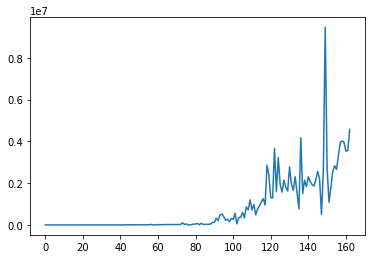

In [86]:
N = 163
com_res = np.zeros((N, 5), dtype=int)
com_res[:, :4] = res3
for i in range(N):
    for j in range(N):
        if np.all(res2[j, :3] == com_res[i, :3]):
            com_res[i, 4] = res2[j, 3]
print(com_res)
plt.plot(com_res[:, -1])
#plt.ylim([0, 0.4e7])
plt.show()

In [63]:
#test:
infile = "/Users/shenyang/Documents/NaBr/INS-code/QEI_no_nan_no_zero.csv"
W = np.array([[-1, 1, 1], [1, -1, 1], [1, 1, -1]])
res3 = occupancy_BZ_near(infile, W, grid=0.05)
print(res3)

Transform applied...
[[  -1    1   -1    2]
 [   2    2   -2    2]
 [  -3   -3    0    2]
 [   1   -1   -2    2]
 [   0   -2   -5    8]
 [  -2    0   -5   10]
 [  -1    0   -5   14]
 [   1    2    0   19]
 [  -4   -2   -1   24]
 [  -3   -1    0   37]
 [   0   -1   -5   38]
 [   1   -1   -1   38]
 [   2    1    0   40]
 [  -5   -3   -3   46]
 [  -4   -2   -5   47]
 [  -2   -4   -1   49]
 [  -3   -1   -5   51]
 [  -1   -3    0   56]
 [  -5   -3   -4   56]
 [  -2   -4   -5   60]
 [  -3   -4   -1   64]
 [  -4   -3   -1   71]
 [  -1   -3   -5   72]
 [   0    2    0   72]
 [   0    2   -3   79]
 [  -3   -5   -4   82]
 [  -1    1   -4   85]
 [  -3   -5   -3   85]
 [   0   -1    1   94]
 [  -5   -4   -4  100]
 [  -4   -5   -3  109]
 [  -1    0    1  110]
 [  -5   -4   -3  110]
 [  -1   -1    1  117]
 [   1    2    1  122]
 [   2    1    1  123]
 [  -1    1   -3  131]
 [  -3   -2    0  136]
 [   2    0    0  141]
 [   1    1   -4  143]
 [  -4   -5   -4  143]
 [   0    2    1  147]
 [  -2   -3  

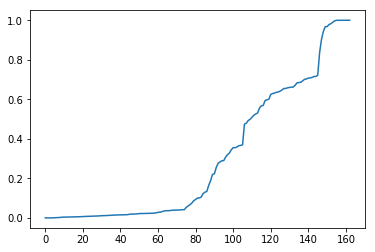

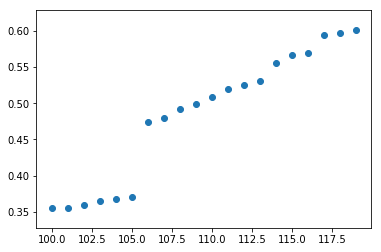

In [89]:
plt.plot(res3[:, -1]/9261.)
plt.show()
plt.cla()
plt.scatter(np.arange(100, 120), res3[100:120, -1]/9261.)
plt.show()

In [90]:
np.savetxt("HKL_op.txt", res3)